# Install Transformers Library

In [37]:
!pip install transformers

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [39]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [40]:
df.shape

(5572, 2)

# Spliting

In [41]:
df['label'].value_counts(normalize = True)
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [42]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization

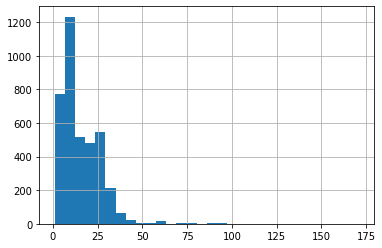

In [43]:
# get length of the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [44]:
max_seq_len = 128

In [45]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#  the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [46]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Freeze BERT Parameters

In [47]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# DataLoaders

In [48]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)

# data loader 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# class Model 

In [49]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [50]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [51]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [52]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.57743559 3.72848948]


 # BERT

In [53]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):  
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients 
    model.zero_grad()
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [54]:
# function for evaluating the model
def evaluate():
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step,batch in enumerate(val_dataloader):
    
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad(): 
      # model predictions
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [55]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Start Model Training

In [56]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.391
Validation Loss: 0.241

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.195
Validation Loss: 0.135

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.186
Validation Loss: 0.098

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.226
Validation Loss: 0.166

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.176
Validation Loss: 0.295

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.178
Validation Loss: 0.101

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.133
Validation Loss: 0.119

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.153
Validation Loss: 0.093

 Epoch 9 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Training Loss: 0.169
Validation Loss

# Predictions

1.   List item
2.   List item



In [57]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [58]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.89      0.96      0.92       112

    accuracy                           0.98       836
   macro avg       0.94      0.97      0.96       836
weighted avg       0.98      0.98      0.98       836



In [59]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,710,14
1,4,108


In [60]:
# fine tuning (freezsoft max) to inhance f1 
# event shooting 

# references
https://pysnacks.com/bert-text-classification-with-fine-tuning/**bold text**
https://github.com/huggingface/transformers
https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
https://arxiv.org/pdf/2004.04917v1.pdf

https://arxiv.org/abs/1711.05101
https://medium.com/swlh a-simple-guide-on-using-bert-for-text-classification-**bbf041ac8d04**
https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/#:~:text=for%20Spam%20Classification-,Transfer%20Learning%20in%20NLP,similar%20tasks%20on%20another%20dataset.&text=Most%20of%20the%20tasks%20in,modeling%2C%20machine%20translation%2C%20etc.
https://stackoverflow.com/questions/60408901/sklearn-utils-compute-class-weight-function-for-large-dataset
https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613